# 1. Install libraries

In [ ]:
!pip install synthcity
!pip install tensorflow-addons
!pip install torch
!pip install numba
!pip install livelossplot
!pip install auton-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1.1 Install Libraries For Training Data

In [ ]:
import math
import os
import random
import itertools


import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from google.colab import drive, files
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from livelossplot import PlotLossesKeras
from IPython.display import clear_output
from auton_survival import datasets, preprocessing, models
from sklearn.model_selection import train_test_split

import torch
from torch import nn, matmul
from torch.nn.functional import softmax


clear_output()

## 1.2 Install Libraries For Generating Data

In [ ]:
# stdlib
import sys
import warnings

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import TimeSeriesSurvivalDataLoader
from synthcity.utils.datasets.time_series.pbc import PBCDataloader

log.add(sink=sys.stderr, level="INFO")
warnings.filterwarnings("ignore")

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [ ]:
(
    static_surv,
    temporal_surv,
    temporal_surv_horizons,
    outcome_surv,
) = PBCDataloader().load()
T, E = outcome_surv

horizons = [0.25, 0.5, 0.75]
time_horizons = np.quantile(T, horizons).tolist()

loader = TimeSeriesSurvivalDataLoader(
    temporal_data=temporal_surv,
    observation_times=temporal_surv_horizons,
    static_data=static_surv,
    T=T,
    E=E,
    time_horizons=time_horizons,
)

In [ ]:
pbc2_dataframe_original = loader.dataframe()
pbc2_dataframe_original

In [ ]:
print(type(loader))

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

Plugins(categories=["generic", "time_series"]).list()

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

syn_model = Plugins().get("timegan")

syn_model.fit(loader)

In [ ]:
pbc2_dataframe_generated = syn_model.generate(count=300).dataframe()

In [ ]:
pbc2_dataframe_generated

In [ ]:
# synthcity absolute
from synthcity.benchmark import Benchmarks

score = Benchmarks.evaluate(
    [
        (f"test_{model}", model, {})
        for model in ["timegan", "bayesian_network", "rtvae"]
    ],
    loader,
    synthetic_size=500,
    repeats=1,
    task_type="time_series_survival",  # time_series_survival or time_series
)

In [ ]:
Benchmarks.print(score)


# 2. Training On Original Data Frame

# 3. Generating SUPPORT Data




In [ ]:
!pip install synthcity
!pip install auton-survival

In [ ]:
import math
import os
import random
import itertools


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive, files

import torch

In [ ]:
from auton_survival import datasets

In [ ]:
files.upload()

In [ ]:
def load_support():

  """Helper function to load and preprocess the SUPPORT dataset.
  The SUPPORT Dataset comes from the Vanderbilt University study
  to estimate survival for seriously ill hospitalized adults [1].
  Please refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
  for the original datasource.

  References
  ----------
  [1]: Knaus WA, Harrell FE, Lynn J et al. (1995): The SUPPORT prognostic
  model: Objective estimates of survival for seriously ill hospitalized
  adults. Annals of Internal Medicine 122:191-203.
  """

  # data = pkgutil.get_data(__name__, '')
  data = pd.read_csv("/content/support2_original.csv")

  drop_cols = ['death', 'd.time']

  outcomes = data.copy()
  outcomes['event'] =  data['death']
  outcomes['time'] = data['d.time']
  outcomes = outcomes[['event', 'time']]

  cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
  num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp',
               'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
               'glucose', 'bun', 'urine', 'adlp', 'adls']

  return outcomes, data[cat_feats+num_feats]

In [ ]:
outcomes, features = load_support()

In [ ]:
features.head()

,sex,dzgroup,dzclass,income,race,ca,age,num.co,meanbp,wblc,...,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls
0,male,Lung Cancer,Cancer,$11-$25k,other,metastatic,62.84998,0,97.0,6.000000,...,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0
1,female,Cirrhosis,COPD/CHF/Cirrhosis,$11-$25k,white,no,60.33899,2,43.0,17.097656,...,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0
2,female,Cirrhosis,COPD/CHF/Cirrhosis,under $11k,white,no,52.74698,2,70.0,8.500000,...,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0
3,female,Lung Cancer,Cancer,under $11k,white,metastatic,42.38498,2,75.0,9.099609,...,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0
4,female,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,79.88495,1,59.0,13.500000,...,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0


In [ ]:
outcomes.head()

,event,time
0,0,2029
1,1,4
2,1,47
3,1,133
4,0,2029


In [ ]:
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp',
               'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
               'glucose', 'bun', 'urine', 'adlp', 'adls']

In [ ]:
from auton_survival import datasets, preprocessing

features = preprocessing.Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)

In [ ]:
features.head()

,age,num.co,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,...,dzclass_Coma,income_$25-$50k,income_>$50k,income_under $11k,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes
0,0.012772,-1.390013,0.449837,-0.693182,-0.892283,-0.138967,-0.881504,1.569019e+00,-1.655686e+00,-5.238337e-01,...,0,0,0,0,0,0,1,0,0,0
1,-0.148262,0.097711,-1.500702,0.518710,0.470382,1.114591,-2.005013,-1.495658e+00,-6.389701e-16,9.880260e-17,...,0,0,0,0,0,0,0,1,1,0
2,-0.635153,0.097711,-0.525432,-0.420176,-0.290175,0.487812,0.235766,-8.319880e-02,-6.389701e-16,-7.892740e-02,...,0,0,0,1,0,0,0,1,1,0
3,-1.299688,0.097711,-0.344827,-0.354697,-0.290175,0.905665,-1.680444,-3.003564e-16,-6.389701e-16,9.880260e-17,...,0,0,0,1,0,0,0,1,0,0
4,1.105258,-0.646151,-0.922764,0.125837,0.470382,-0.347893,0.635237,-6.997670e-01,-6.389701e-16,9.880260e-17,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
support2_data = pd.concat([outcomes,features], axis=1, join='inner')

In [ ]:
support2_data = support2_data.fillna(0)

In [ ]:
support2_data

,event,time,sex,dzgroup,dzclass,income,race,ca,age,num.co,...,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls
0,0,2029,male,Lung Cancer,Cancer,$11-$25k,other,metastatic,62.84998,0,...,1.799805,0.199982,1.199951,141.0,7.459961,0.0,0.0,0.0,7.0,7.0
1,1,4,female,Cirrhosis,COPD/CHF/Cirrhosis,$11-$25k,white,no,60.33899,2,...,0.000000,0.000000,5.500000,132.0,7.250000,0.0,0.0,0.0,0.0,1.0
2,1,47,female,Cirrhosis,COPD/CHF/Cirrhosis,under $11k,white,no,52.74698,2,...,0.000000,2.199707,2.000000,134.0,7.459961,0.0,0.0,0.0,1.0,0.0
3,1,133,female,Lung Cancer,Cancer,under $11k,white,metastatic,42.38498,2,...,0.000000,0.000000,0.799927,139.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0,2029,female,ARF/MOSF w/Sepsis,ARF/MOSF,0,white,no,79.88495,1,...,0.000000,0.000000,0.799927,143.0,7.509766,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,0,350,male,ARF/MOSF w/Sepsis,ARF/MOSF,0,white,no,66.07300,1,...,3.699707,0.399963,1.099854,131.0,7.459961,188.0,21.0,0.0,0.0,0.0
9101,0,347,female,Coma,Coma,0,white,no,55.15399,1,...,0.000000,0.000000,5.899414,135.0,7.289062,190.0,49.0,0.0,0.0,0.0
9102,0,346,male,ARF/MOSF w/Sepsis,ARF/MOSF,0,white,no,70.38196,1,...,0.000000,0.399963,2.699707,139.0,7.379883,189.0,60.0,3900.0,0.0,0.0
9103,1,7,male,MOSF w/Malig,ARF/MOSF,0,white,yes,47.01999,1,...,1.199951,0.399963,3.500000,135.0,7.469727,246.0,55.0,0.0,0.0,0.0


In [ ]:
support2_data.to_csv('support2_processed.csv',index=True)

In [ ]:
list(support2_data.columns)

['event',
 'time',
 'age',
 'num.co',
 'meanbp',
 'wblc',
 'hrt',
 'resp',
 'temp',
 'pafi',
 'alb',
 'bili',
 'crea',
 'sod',
 'ph',
 'glucose',
 'bun',
 'urine',
 'adlp',
 'adls',
 'sex_male',
 'dzgroup_CHF',
 'dzgroup_COPD',
 'dzgroup_Cirrhosis',
 'dzgroup_Colon Cancer',
 'dzgroup_Coma',
 'dzgroup_Lung Cancer',
 'dzgroup_MOSF w/Malig',
 'dzclass_COPD/CHF/Cirrhosis',
 'dzclass_Cancer',
 'dzclass_Coma',
 'income_$25-$50k',
 'income_>$50k',
 'income_under $11k',
 'race_black',
 'race_hispanic',
 'race_other',
 'race_white',
 'ca_no',
 'ca_yes']

In [ ]:
# stdlib
import sys
import warnings

warnings.filterwarnings("ignore")

# third party
from sklearn.datasets import load_diabetes

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader, SurvivalAnalysisDataLoader
log.add(sink=sys.stderr, level="INFO")

# X, y = load_diabetes(return_X_y=True, as_frame=True)
# X["target"] = y

# X

In [ ]:
# for adsgan
loader = GenericDataLoader(
    support2_data,
    target_column="time",
    sensitive_columns=['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp',
               'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
               'glucose', 'bun', 'urine', 'adlp', 'adls', 'event'],
)

# for survival_gan
# loader = SurvivalAnalysisDataLoader(
#     support2_data,
#     target_column="event",
#     time_to_event_column="time",
#     sensitive_columns=['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp',
#                'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph',
#                'glucose', 'bun', 'urine', 'adlp', 'adls'],
# )

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

Plugins().list()

[2023-07-01T19:53:21.371992+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-01T19:53:21.371992+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-01T19:53:21.371992+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-01T19:53:21.371992+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py


['fflows',
 'pategan',
 'survival_ctgan',
 'ddpm',
 'nflow',
 'privbayes',
 'survival_nflow',
 'survae',
 'survival_gan',
 'timevae',
 'dpgan',
 'radialgan',
 'timegan',
 'adsgan',
 'image_adsgan',
 'rtvae',
 'decaf',
 'ctgan',
 'tvae',
 'image_cgan',
 'bayesian_network']

In [ ]:
from synthcity.plugins import Plugins

syn_model = Plugins().get("adsgan")

syn_model.fit(loader)

[2023-07-01T19:55:53.091654+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-01T19:55:53.091654+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-01T19:55:53.091654+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-01T19:55:53.091654+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-01T19:55:53.091654+0000][605][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py


TypeError: ignored

In [ ]:
support2_generated = syn_model.generate(count=5463).dataframe()

In [ ]:
support2_generated

,event,time,age,num.co,meanbp,wblc,hrt,resp,temp,pafi,...,dzclass_Coma,income_$25-$50k,income_>$50k,income_under $11k,race_black,race_hispanic,race_other,race_white,ca_no,ca_yes
0,0,606,-1.205747,-1.390013,1.793768,-0.947399,-1.156615,0.851779,1.048948,0.002760,...,0,1,0,0,0,0,0,0,1,0
1,1,50,0.154458,0.841573,0.987548,-0.940773,-0.929382,1.217835,-1.078303,-0.011583,...,0,0,0,0,0,0,0,1,0,0
2,1,144,0.557528,0.097711,-0.308938,-0.568573,-0.954283,-0.958336,-1.378881,-0.022159,...,0,0,0,0,0,0,0,1,0,0
3,1,170,-0.796920,0.841573,1.573544,-0.108747,-0.871792,0.122288,0.509476,-0.000356,...,0,1,0,0,0,0,0,1,0,0
4,0,872,0.541362,0.841573,0.838692,0.076337,-1.041307,-0.990801,-0.815941,-0.006524,...,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,1,36,1.526641,5.304745,-0.499036,-0.136958,0.705287,1.363502,-0.749378,-0.006617,...,0,0,0,0,0,0,0,1,1,0
5459,1,166,-0.678323,-0.646151,-0.358135,-0.349618,-0.231074,0.220399,-0.939859,-0.041896,...,0,0,0,1,0,0,0,1,0,0
5460,1,195,0.826218,-0.646151,1.086487,-0.800371,-1.099792,-0.283857,-0.687532,-0.008529,...,0,0,0,0,0,0,0,1,0,0
5461,1,155,0.417070,-0.646151,1.125123,-1.031798,0.546419,0.189222,-1.843772,-0.118149,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
support2_merged = pd.concat([support2_data, support2_generated], ignore_index=True)

In [ ]:
support2_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14568 entries, 0 to 14567
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   event                       14568 non-null  int64  
 1   time                        14568 non-null  int64  
 2   age                         14568 non-null  float64
 3   num.co                      14568 non-null  float64
 4   meanbp                      14568 non-null  float64
 5   wblc                        14568 non-null  float64
 6   hrt                         14568 non-null  float64
 7   resp                        14568 non-null  float64
 8   temp                        14568 non-null  float64
 9   pafi                        14568 non-null  float64
 10  alb                         14568 non-null  float64
 11  bili                        14568 non-null  float64
 12  crea                        14568 non-null  float64
 13  sod                         145

In [ ]:
support2_merged.to_csv('support2_merged_survgan_auton.csv',index=False)

# 4. Generating METABRIC Data


In [ ]:
!pip install synthcity
!pip install auton-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import math
import os
import random
import itertools


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive, files

import torch

In [ ]:
files.upload()

Saving metabric_original.csv to metabric_original.csv


{'metabric_original.csv': b'age_at_diagnosis,size,lymph_nodes_positive,stage,lymph_nodes_removed,NPI,grade,grade,grade,histological,histological,histological,histological,histological,histological,histological,histological,histological,histological,histological,histological,ER_IHC_status,ER_IHC_status,ER_Expr,ER_Expr,PR_Expz,PR_Expz,HER2_IHC_status,HER2_IHC_status,HER2_IHC_status,HER2_IHC_status,HER2_SNP6_state,HER2_SNP6_state,HER2_SNP6_state,Her2_Expr,Her2_Expr,Treatment,Treatment,Treatment,Treatment,Treatment,Treatment,Treatment,Treatment,inf_men_status,inf_men_status,group,group,group,group,group,cellularity,cellularity,cellularity,Pam50_Subtype,Pam50_Subtype,Pam50_Subtype,Pam50_Subtype,Pam50_Subtype,Pam50_Subtype,int_clust_memb,int_clust_memb,int_clust_memb,int_clust_memb,int_clust_memb,int_clust_memb,int_clust_memb,int_clust_memb,int_clust_memb,int_clust_memb,site,site,site,site,site,Genefu,Genefu,Genefu,Genefu,event_time,label\r\n75.65,22,10,2,16,6.04,0,0,1,0,1,0,0,0,0,0,0,0,0,0,

In [ ]:
df = pd.read_csv("/content/metabric_processed.csv")
metabric_data = df

In [ ]:
def load_metabric():

  """Helper function to load and preprocess the SUPPORT dataset.
  The SUPPORT Dataset comes from the Vanderbilt University study
  to estimate survival for seriously ill hospitalized adults [1].
  Please refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
  for the original datasource.

  References
  ----------
  [1]: Knaus WA, Harrell FE, Lynn J et al. (1995): The SUPPORT prognostic
  model: Objective estimates of survival for seriously ill hospitalized
  adults. Annals of Internal Medicine 122:191-203.
  """

  # data = pkgutil.get_data(__name__, '')
  data = pd.read_csv("/content/metabric_original.csv")

  drop_cols = ['label', 'event_time']

  outcomes = data.copy()
  outcomes['event'] =  data['label']
  outcomes['time'] = data['event_time']
  outcomes = outcomes[['event', 'time']]

  num_feats = ['age_at_diagnosis', 'size', 'lymph_nodes_positive', 'lymph_nodes_removed', 'NPI']
  cat_feats = ['stage','grade','grade.1','grade.2','histological','histological.1','histological.2','histological.3','histological.4','histological.5','histological.6','histological.7','histological.8','histological.9','histological.10','histological.11','ER_IHC_status','ER_IHC_status.1','ER_Expr','ER_Expr.1','PR_Expz','PR_Expz.1','HER2_IHC_status','HER2_IHC_status.1','HER2_IHC_status.2','HER2_IHC_status.3','HER2_SNP6_state','HER2_SNP6_state.1','HER2_SNP6_state.2','Her2_Expr','Her2_Expr.1','Treatment','Treatment.1','Treatment.2','Treatment.3','Treatment.4','Treatment.5','Treatment.6','Treatment.7','inf_men_status','inf_men_status.1','group','group.1','group.2','group.3','group.4','cellularity','cellularity.1','cellularity.2','Pam50_Subtype','Pam50_Subtype.1','Pam50_Subtype.2','Pam50_Subtype.3','Pam50_Subtype.4','Pam50_Subtype.5','int_clust_memb','int_clust_memb.1','int_clust_memb.2','int_clust_memb.3','int_clust_memb.4','int_clust_memb.5','int_clust_memb.6','int_clust_memb.7','int_clust_memb.8','int_clust_memb.9','site','site.1','site.2','site.3','site.4','Genefu','Genefu.1','Genefu.2','Genefu.3']


  return outcomes, data[cat_feats+num_feats]

In [ ]:
outcomes, features = load_metabric()

In [ ]:
features.head()

,grade,grade.1,grade.2,histological,histological.1,histological.2,histological.3,histological.4,histological.5,histological.6,...,Genefu,Genefu.1,Genefu.2,Genefu.3,age_at_diagnosis,size,lymph_nodes_positive,stage,lymph_nodes_removed,NPI
0,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,75.65,22.0,10.0,2.0,16.0,6.04
1,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,43.19,10.0,0.0,1.0,25.0,4.02
2,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,48.87,15.0,1.0,2.0,12.0,4.03
3,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,47.68,25.0,3.0,2.0,21.0,4.05
4,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,76.97,40.0,8.0,2.0,8.0,6.08


In [ ]:
outcomes.head()

,event,time
0,0,2999
1,0,1484
2,0,3053
3,0,1721
4,1,1241


In [ ]:
num_feats = ['age_at_diagnosis', 'size', 'lymph_nodes_positive', 'lymph_nodes_removed', 'NPI']
cat_feats = ['stage','grade','grade.1','grade.2','histological','histological.1','histological.2','histological.3','histological.4','histological.5','histological.6','histological.7','histological.8','histological.9','histological.10','histological.11','ER_IHC_status','ER_IHC_status.1','ER_Expr','ER_Expr.1','PR_Expz','PR_Expz.1','HER2_IHC_status','HER2_IHC_status.1','HER2_IHC_status.2','HER2_IHC_status.3','HER2_SNP6_state','HER2_SNP6_state.1','HER2_SNP6_state.2','Her2_Expr','Her2_Expr.1','Treatment','Treatment.1','Treatment.2','Treatment.3','Treatment.4','Treatment.5','Treatment.6','Treatment.7','inf_men_status','inf_men_status.1','group','group.1','group.2','group.3','group.4','cellularity','cellularity.1','cellularity.2','Pam50_Subtype','Pam50_Subtype.1','Pam50_Subtype.2','Pam50_Subtype.3','Pam50_Subtype.4','Pam50_Subtype.5','int_clust_memb','int_clust_memb.1','int_clust_memb.2','int_clust_memb.3','int_clust_memb.4','int_clust_memb.5','int_clust_memb.6','int_clust_memb.7','int_clust_memb.8','int_clust_memb.9','site','site.1','site.2','site.3','site.4','Genefu','Genefu.1','Genefu.2','Genefu.3']


In [ ]:
from auton_survival import datasets, preprocessing

features = preprocessing.Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)

In [ ]:
features.head()

,age_at_diagnosis,size,lymph_nodes_positive,stage,lymph_nodes_removed,NPI,grade_1,grade.1_1,grade.2_1,histological_1,...,int_clust_memb.9_1,site_1,site.1_1,site.2_1,site.3_1,site.4_1,Genefu_1,Genefu.1_1,Genefu.2_1,Genefu.3_1
0,1.145884,-0.236126,2.132240,0.967813,0.384511,1.803566,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,-1.332595,-1.071645,-0.470303,-0.227537,1.476070,0.024926,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,-0.898900,-0.723512,-0.210048,0.967813,-0.100627,0.033732,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,-0.989762,-0.027246,0.310460,0.967813,0.990933,0.051342,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,1.246672,1.017153,1.611732,0.967813,-0.585765,1.838787,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
metabric_data = pd.concat([outcomes,features], axis=1, join='inner')

In [ ]:
metabric_data.to_csv('metabric_processed.csv',index=False)

In [ ]:
metabric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981 entries, 0 to 1980
Data columns (total 81 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event                 1981 non-null   int64  
 1   time                  1981 non-null   int64  
 2   age_at_diagnosis      1981 non-null   float64
 3   size                  1981 non-null   float64
 4   lymph_nodes_positive  1981 non-null   float64
 5   stage                 1981 non-null   float64
 6   lymph_nodes_removed   1981 non-null   float64
 7   NPI                   1981 non-null   float64
 8   grade_1               1981 non-null   uint8  
 9   grade.1_1             1981 non-null   uint8  
 10  grade.2_1             1981 non-null   uint8  
 11  histological_1        1981 non-null   uint8  
 12  histological.1_1      1981 non-null   uint8  
 13  histological.2_1      1981 non-null   uint8  
 14  histological.3_1      1981 non-null   uint8  
 15  histological.4_1     

In [ ]:
list(metabric_data.columns)

['event',
 'time',
 'stage',
 'grade',
 'grade.1',
 'grade.2',
 'histological',
 'histological.1',
 'histological.2',
 'histological.3',
 'histological.4',
 'histological.5',
 'histological.6',
 'histological.7',
 'histological.8',
 'histological.9',
 'histological.10',
 'histological.11',
 'ER_IHC_status',
 'ER_IHC_status.1',
 'ER_Expr',
 'ER_Expr.1',
 'PR_Expz',
 'PR_Expz.1',
 'HER2_IHC_status',
 'HER2_IHC_status.1',
 'HER2_IHC_status.2',
 'HER2_IHC_status.3',
 'HER2_SNP6_state',
 'HER2_SNP6_state.1',
 'HER2_SNP6_state.2',
 'Her2_Expr',
 'Her2_Expr.1',
 'Treatment',
 'Treatment.1',
 'Treatment.2',
 'Treatment.3',
 'Treatment.4',
 'Treatment.5',
 'Treatment.6',
 'Treatment.7',
 'inf_men_status',
 'inf_men_status.1',
 'group',
 'group.1',
 'group.2',
 'group.3',
 'group.4',
 'cellularity',
 'cellularity.1',
 'cellularity.2',
 'Pam50_Subtype',
 'Pam50_Subtype.1',
 'Pam50_Subtype.2',
 'Pam50_Subtype.3',
 'Pam50_Subtype.4',
 'Pam50_Subtype.5',
 'int_clust_memb',
 'int_clust_memb.1',
 'int

In [ ]:
# stdlib
import sys
import warnings

warnings.filterwarnings("ignore")

# third party
from sklearn.datasets import load_diabetes

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader, SurvivalAnalysisDataLoader

log.add(sink=sys.stderr, level="INFO")

# X, y = load_diabetes(return_X_y=True, as_frame=True)
# X["target"] = y

# X

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [ ]:
list(metabric_data.columns)

['event',
 'time',
 'stage',
 'grade',
 'grade.1',
 'grade.2',
 'histological',
 'histological.1',
 'histological.2',
 'histological.3',
 'histological.4',
 'histological.5',
 'histological.6',
 'histological.7',
 'histological.8',
 'histological.9',
 'histological.10',
 'histological.11',
 'ER_IHC_status',
 'ER_IHC_status.1',
 'ER_Expr',
 'ER_Expr.1',
 'PR_Expz',
 'PR_Expz.1',
 'HER2_IHC_status',
 'HER2_IHC_status.1',
 'HER2_IHC_status.2',
 'HER2_IHC_status.3',
 'HER2_SNP6_state',
 'HER2_SNP6_state.1',
 'HER2_SNP6_state.2',
 'Her2_Expr',
 'Her2_Expr.1',
 'Treatment',
 'Treatment.1',
 'Treatment.2',
 'Treatment.3',
 'Treatment.4',
 'Treatment.5',
 'Treatment.6',
 'Treatment.7',
 'inf_men_status',
 'inf_men_status.1',
 'group',
 'group.1',
 'group.2',
 'group.3',
 'group.4',
 'cellularity',
 'cellularity.1',
 'cellularity.2',
 'Pam50_Subtype',
 'Pam50_Subtype.1',
 'Pam50_Subtype.2',
 'Pam50_Subtype.3',
 'Pam50_Subtype.4',
 'Pam50_Subtype.5',
 'int_clust_memb',
 'int_clust_memb.1',
 'int

In [ ]:
sensitive_columns=['event','age_at_diagnosis','size','lymph_nodes_positive','stage_1.0','stage_1.190352021','stage_2.0','stage_3.0','stage_4.0','lymph_nodes_removed','NPI','grade_1','grade.1_1','grade.2_1','histological_1','histological.1_1','histological.2_1','histological.3_1','histological.4_1','histological.5_1','histological.6_1','histological.7_1','histological.8_1','histological.9_1','histological.10_1','histological.11_1','ER_IHC_status_1','ER_IHC_status.1_1','ER_Expr_1','ER_Expr.1_1','PR_Expz_1','PR_Expz.1_1','HER2_IHC_status_1','HER2_IHC_status.1_1','HER2_IHC_status.2_1','HER2_IHC_status.3_1','HER2_SNP6_state_1','HER2_SNP6_state.1_1','HER2_SNP6_state.2_1','Her2_Expr_1','Her2_Expr.1_1','Treatment_1','Treatment.1_1','Treatment.2_1','Treatment.3_1','Treatment.4_1','Treatment.5_1','Treatment.6_1','Treatment.7_1','inf_men_status_1','inf_men_status.1_1','group_1','group.1_1','group.2_1','group.3_1','group.4_1','cellularity_1','cellularity.1_1','cellularity.2_1','Pam50_Subtype_1','Pam50_Subtype.1_1','Pam50_Subtype.2_1','Pam50_Subtype.3_1','Pam50_Subtype.4_1','Pam50_Subtype.5_1','int_clust_memb_1','int_clust_memb.1_1','int_clust_memb.2_1','int_clust_memb.3_1','int_clust_memb.4_1','int_clust_memb.5_1','int_clust_memb.6_1','int_clust_memb.7_1','int_clust_memb.8_1','int_clust_memb.9_1','site_1','site.1_1','site.2_1','site.3_1','site.4_1','Genefu_1','Genefu.1_1','Genefu.2_1','Genefu.3_1']
b = ['event','time','age_at_diagnosis','size','lymph_nodes_positive','lymph_nodes_removed','NPI','stage_1.0','stage_1.190352021','stage_2.0','stage_3.0','stage_4.0','grade_1','grade.1_1','grade.2_1','histological_1','histological.1_1','histological.2_1','histological.3_1','histological.4_1','histological.5_1','histological.6_1','histological.7_1','histological.8_1','histological.9_1','histological.10_1','histological.11_1','ER_IHC_status_1','ER_IHC_status.1_1','ER_Expr_1','ER_Expr.1_1','PR_Expz_1','PR_Expz.1_1','HER2_IHC_status_1','HER2_IHC_status.1_1','HER2_IHC_status.2_1','HER2_IHC_status.3_1','HER2_SNP6_state_1','HER2_SNP6_state.1_1','HER2_SNP6_state.2_1','Her2_Expr_1','Her2_Expr.1_1','Treatment_1','Treatment.1_1','Treatment.2_1','Treatment.3_1','Treatment.4_1','Treatment.5_1','Treatment.6_1','Treatment.7_1','inf_men_status_1','inf_men_status.1_1','group_1','group.1_1','group.2_1','group.3_1','group.4_1','cellularity_1','cellularity.1_1','cellularity.2_1','Pam50_Subtype_1','Pam50_Subtype.1_1','Pam50_Subtype.2_1','Pam50_Subtype.3_1','Pam50_Subtype.4_1','Pam50_Subtype.5_1','int_clust_memb_1','int_clust_memb.1_1','int_clust_memb.2_1','int_clust_memb.3_1','int_clust_memb.4_1','int_clust_memb.5_1','int_clust_memb.6_1','int_clust_memb.7_1','int_clust_memb.8_1','int_clust_memb.9_1','site_1','site.1_1','site.2_1','site.3_1','site.4_1','Genefu_1','Genefu.1_1','Genefu.2_1','Genefu.3_1']
print(len(sensitive_columns))

84


In [ ]:
# for adsgan
# loader = GenericDataLoader(
#     metabric_data,
#     target_column="time",
#     sensitive_columns=['event','stage','grade','grade.1','grade.2','histological','histological.1','histological.2','histological.3','histological.4','histological.5','histological.6','histological.7','histological.8','histological.9','histological.10','histological.11','ER_IHC_status','ER_IHC_status.1','ER_Expr','ER_Expr.1','PR_Expz','PR_Expz.1','HER2_IHC_status','HER2_IHC_status.1','HER2_IHC_status.2','HER2_IHC_status.3','HER2_SNP6_state','HER2_SNP6_state.1','HER2_SNP6_state.2','Her2_Expr','Her2_Expr.1','Treatment','Treatment.1','Treatment.2','Treatment.3','Treatment.4','Treatment.5','Treatment.6','Treatment.7','inf_men_status','inf_men_status.1','group','group.1','group.2','group.3','group.4','cellularity','cellularity.1','cellularity.2','Pam50_Subtype','Pam50_Subtype.1','Pam50_Subtype.2','Pam50_Subtype.3','Pam50_Subtype.4','Pam50_Subtype.5','int_clust_memb','int_clust_memb.1','int_clust_memb.2','int_clust_memb.3','int_clust_memb.4','int_clust_memb.5','int_clust_memb.6','int_clust_memb.7','int_clust_memb.8','int_clust_memb.9','site','site.1','site.2','site.3','site.4','Genefu','Genefu.1','Genefu.2','Genefu.3'],
# )

#cat_feats = ['stage','grade','grade.1','grade.2','histological','histological.1','histological.2','histological.3','histological.4','histological.5','histological.6','histological.7','histological.8','histological.9','histological.10','histological.11','ER_IHC_status','ER_IHC_status.1','ER_Expr','ER_Expr.1','PR_Expz','PR_Expz.1','HER2_IHC_status','HER2_IHC_status.1','HER2_IHC_status.2','HER2_IHC_status.3','HER2_SNP6_state','HER2_SNP6_state.1','HER2_SNP6_state.2','Her2_Expr','Her2_Expr.1','Treatment','Treatment.1','Treatment.2','Treatment.3','Treatment.4','Treatment.5','Treatment.6','Treatment.7','inf_men_status','inf_men_status.1','group','group.1','group.2','group.3','group.4','cellularity','cellularity.1','cellularity.2','Pam50_Subtype','Pam50_Subtype.1','Pam50_Subtype.2','Pam50_Subtype.3','Pam50_Subtype.4','Pam50_Subtype.5','int_clust_memb','int_clust_memb.1','int_clust_memb.2','int_clust_memb.3','int_clust_memb.4','int_clust_memb.5','int_clust_memb.6','int_clust_memb.7','int_clust_memb.8','int_clust_memb.9','site','site.1','site.2','site.3','site.4','Genefu','Genefu.1','Genefu.2','Genefu.3']
#     sensitive_columns=['age_at_diagnosis','size','lymph_nodes_positive','stage_1.0','stage_1.190352021','stage_2.0','stage_3.0','stage_4.0','lymph_nodes_removed','NPI','grade_1','grade.1_1','grade.2_1','histological_1','histological.1_1','histological.2_1','histological.3_1','histological.4_1','histological.5_1','histological.6_1','histological.7_1','histological.8_1','histological.9_1','histological.10_1','histological.11_1','ER_IHC_status_1','ER_IHC_status.1_1','ER_Expr_1','ER_Expr.1_1','PR_Expz_1','PR_Expz.1_1','HER2_IHC_status_1','HER2_IHC_status.1_1','HER2_IHC_status.2_1','HER2_IHC_status.3_1','HER2_SNP6_state_1','HER2_SNP6_state.1_1','HER2_SNP6_state.2_1','Her2_Expr_1','Her2_Expr.1_1','Treatment_1','Treatment.1_1','Treatment.2_1','Treatment.3_1','Treatment.4_1','Treatment.5_1','Treatment.6_1','Treatment.7_1','inf_men_status_1','inf_men_status.1_1','group_1','group.1_1','group.2_1','group.3_1','group.4_1','cellularity_1','cellularity.1_1','cellularity.2_1','Pam50_Subtype_1','Pam50_Subtype.1_1','Pam50_Subtype.2_1','Pam50_Subtype.3_1','Pam50_Subtype.4_1','Pam50_Subtype.5_1','int_clust_memb_1','int_clust_memb.1_1','int_clust_memb.2_1','int_clust_memb.3_1','int_clust_memb.4_1','int_clust_memb.5_1','int_clust_memb.6_1','int_clust_memb.7_1','int_clust_memb.8_1','int_clust_memb.9_1','site_1','site.1_1','site.2_1','site.3_1','site.4_1','Genefu_1','Genefu.1_1','Genefu.2_1','Genefu.3_1'],


# for survival_gan
loader = SurvivalAnalysisDataLoader(
    metabric_data,
    target_column="event",
    time_to_event_column="time",
    sensitive_columns=['age_at_diagnosis','size','lymph_nodes_positive','stage_1.0','stage_1.190352021','stage_2.0','stage_3.0','stage_4.0','lymph_nodes_removed','NPI','grade_1','grade.1_1','grade.2_1','histological_1','histological.1_1','histological.2_1','histological.3_1','histological.4_1','histological.5_1','histological.6_1','histological.7_1','histological.8_1','histological.9_1','histological.10_1','histological.11_1','ER_IHC_status_1','ER_IHC_status.1_1','ER_Expr_1','ER_Expr.1_1','PR_Expz_1','PR_Expz.1_1','HER2_IHC_status_1','HER2_IHC_status.1_1','HER2_IHC_status.2_1','HER2_IHC_status.3_1','HER2_SNP6_state_1','HER2_SNP6_state.1_1','HER2_SNP6_state.2_1','Her2_Expr_1','Her2_Expr.1_1','Treatment_1','Treatment.1_1','Treatment.2_1','Treatment.3_1','Treatment.4_1','Treatment.5_1','Treatment.6_1','Treatment.7_1','inf_men_status_1','inf_men_status.1_1','group_1','group.1_1','group.2_1','group.3_1','group.4_1','cellularity_1','cellularity.1_1','cellularity.2_1','Pam50_Subtype_1','Pam50_Subtype.1_1','Pam50_Subtype.2_1','Pam50_Subtype.3_1','Pam50_Subtype.4_1','Pam50_Subtype.5_1','int_clust_memb_1','int_clust_memb.1_1','int_clust_memb.2_1','int_clust_memb.3_1','int_clust_memb.4_1','int_clust_memb.5_1','int_clust_memb.6_1','int_clust_memb.7_1','int_clust_memb.8_1','int_clust_memb.9_1','site_1','site.1_1','site.2_1','site.3_1','site.4_1','Genefu_1','Genefu.1_1','Genefu.2_1','Genefu.3_1'],
)

In [ ]:
from synthcity.plugins import Plugins

syn_model = Plugins().get("survival_gan")

syn_model.fit(loader)

[2023-07-02T19:57:27.582518+0000][436][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-02T19:57:29.422017+0000][436][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|▉         | 949/10000 [08:55<1:25:10,  1.77it/s]


In [ ]:
metabric_data_generated = syn_model.generate(count=1190).dataframe()

In [ ]:
metabric_data_merged = pd.concat([metabric_data, metabric_data_generated], ignore_index=True)

In [ ]:
metabric_data_merged.to_csv('metabric_data_merged_survgan_noauton.csv',index=False)

In [ ]:
# synthcity absolute
from synthcity.benchmark import Benchmarks

score = Benchmarks.evaluate(
    [
        (f"test_{model}", model, {})
        for model in ["timegan", "bayesian_network", "rtvae"]
    ],
    loader,
    synthetic_size=500,
    repeats=1,
    task_type="time_series_survival",  # time_series_survival or time_series
)

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

plugins = Plugins().list()

plugins

[2023-06-24T16:45:33.160107+0000][896][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py


['tvae',
 'survae',
 'nflow',
 'rtvae',
 'privbayes',
 'ddpm',
 'adsgan',
 'timevae',
 'radialgan',
 'fflows',
 'image_adsgan',
 'image_cgan',
 'ctgan',
 'survival_gan',
 'decaf',
 'dpgan',
 'survival_ctgan',
 'survival_nflow',
 'bayesian_network',
 'pategan',
 'timegan']

In [ ]:
# synthcity absolute
from synthcity.benchmark import Benchmarks

score = Benchmarks.evaluate(
    [("adsgan", "uniform_sampler",{}), ("adsgan", "marginal_distributions", {}),],
    loader,
    synthetic_size=1000,
    repeats=2,
)

[2023-06-24T16:49:28.295823+0000][896][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-24T16:49:29.613139+0000][896][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py


In [ ]:
Benchmarks.print(score)



Plugin : adsgan


,min,max,mean,stddev,median,iqr,rounds,errors,durations
sanity.data_mismatch.score,0.000000,0.000000,0.000000,0.0,0.000000,0.0,2,0,0.00
sanity.common_rows_proportion.score,0.000000,0.000000,0.000000,0.0,0.000000,0.0,2,0,0.02
sanity.nearest_syn_neighbor_distance.mean,0.220296,0.220296,0.220296,0.0,0.220296,0.0,2,0,0.00
sanity.close_values_probability.score,0.564232,0.564232,0.564232,0.0,0.564232,0.0,2,0,0.00
sanity.distant_values_probability.score,0.010076,0.010076,0.010076,0.0,0.010076,0.0,2,0,0.00
stats.jensenshannon_dist.marginal,0.083625,0.083625,0.083625,0.0,0.083625,0.0,2,0,0.01
stats.chi_squared_test.marginal,0.571873,0.571873,0.571873,0.0,0.571873,0.0,2,0,0.02
stats.inv_kl_divergence.marginal,0.774992,0.774992,0.774992,0.0,0.774992,0.0,2,0,0.01
stats.ks_test.marginal,0.625245,0.625245,0.625245,0.0,0.625245,0.0,2,0,0.02
stats.max_mean_discrepancy.joint,0.005038,0.005038,0.005038,0.0,0.005038,0.0,2,0,0.02


In [ ]:
Benchmarks.highlight(score)


,adsgan
sanity.data_mismatch.score,0.000000
sanity.common_rows_proportion.score,0.000000
sanity.nearest_syn_neighbor_distance.mean,0.220296
sanity.close_values_probability.score,0.564232
sanity.distant_values_probability.score,0.010076
stats.jensenshannon_dist.marginal,0.083625
stats.chi_squared_test.marginal,0.571873
stats.inv_kl_divergence.marginal,0.774992
stats.ks_test.marginal,0.625245
stats.max_mean_discrepancy.joint,0.005038


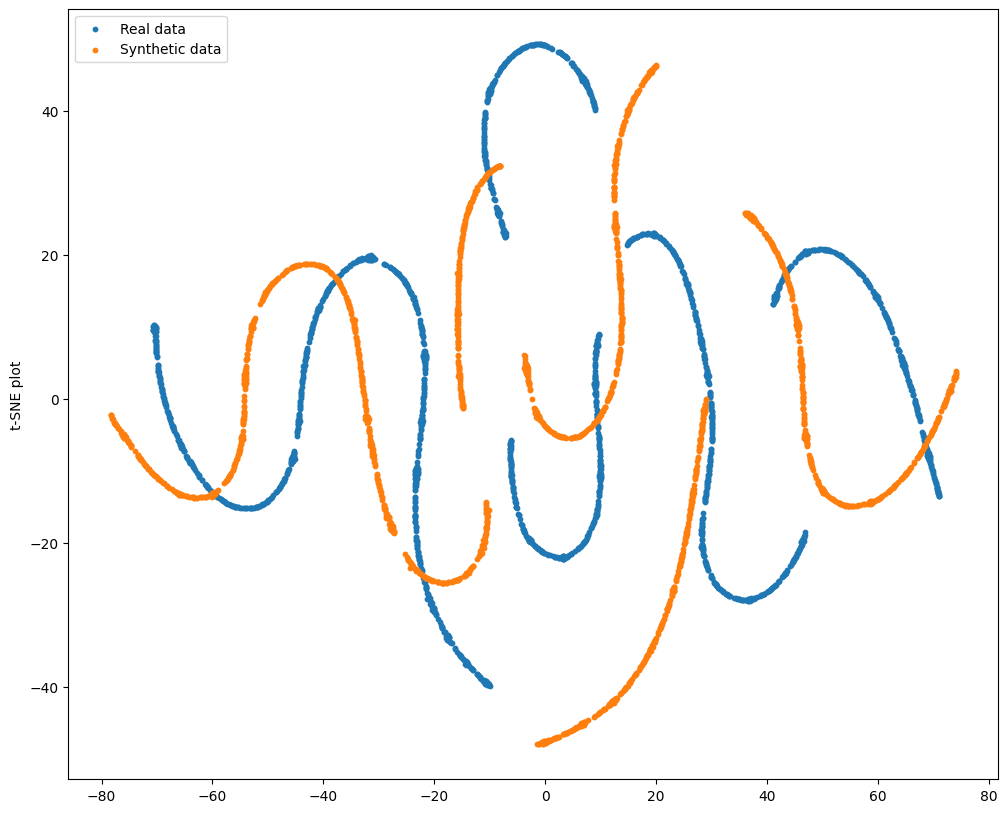

In [ ]:
# third party
import matplotlib.pyplot as plt

syn_model.plot(plt, loader, plots=["tsne"])

plt.show()

# 5. Generating Support Data On PyCox Lib


In [ ]:
!pip install synthcity
!pip install auton-survival

  Using cached synthcity-0.2.6-py3-none-any.whl (355 kB)
  Using cached nflows-0.14.tar.gz (45 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 757.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 10.9 MB/s eta 0:00:00
  Preparing m

In [ ]:
import math
import os
import random
import itertools


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive, files

import torch

In [ ]:
!pip install scikit-survival
!pip install torchtuples
!pip install pycox

In [ ]:
from pycox.datasets import support

In [ ]:
def load_support_pycox():

  """Helper function to load and preprocess the SUPPORT dataset.
  The SUPPORT Dataset comes from the Vanderbilt University study
  to estimate survival for seriously ill hospitalized adults [1].
  Please refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
  for the original datasource.

  References
  ----------
  [1]: Knaus WA, Harrell FE, Lynn J et al. (1995): The SUPPORT prognostic
  model: Objective estimates of survival for seriously ill hospitalized
  adults. Annals of Internal Medicine 122:191-203.
  """

  # data = pkgutil.get_data(__name__, '')
  data = support.read_df()

  drop_cols = ['event', 'duration']

  outcomes = data.copy()
  outcomes['event'] =  data['event']
  outcomes['time'] = data['duration']
  outcomes = outcomes[['event', 'time']]

  cat_feats = ["x1", "x2", "x3", "x4", "x5", "x6"]
  num_feats = ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']

  return outcomes, data[cat_feats+num_feats]

In [ ]:
outcomes, features = load_support_pycox()

Dataset 'support' not locally available. Downloading...
Done


In [ ]:
features.head()

,x1,x2,x3,x4,x5,x6,x0,x7,x8,x9,x10,x11,x12,x13
0,1.0,2.0,1.0,0.0,0.0,0.0,82.709961,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854
1,1.0,0.0,1.0,0.0,0.0,1.0,79.660950,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902
2,1.0,2.0,3.0,0.0,0.0,1.0,23.399990,87.0,144.0,45.0,37.296879,130.0,5.199219,1.199951
3,1.0,4.0,3.0,0.0,0.0,0.0,53.075989,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927
4,0.0,1.0,1.0,0.0,0.0,0.0,71.794983,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963


In [ ]:
cat_feats = ["x1", "x2", "x3", "x4", "x5", "x6"]
num_feats = ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']

In [ ]:
from auton_survival import datasets, preprocessing

features = preprocessing.Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)

In [ ]:
support2_data_pycox = pd.concat([outcomes,features], axis=1, join='inner')

In [ ]:
support2_data_pycox.to_csv('support2_data_pycox_processed_noauton.csv',index=False)

In [ ]:
support2_data_pycox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8873 entries, 0 to 8872
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   event   8873 non-null   int32  
 1   time    8873 non-null   float32
 2   x0      8873 non-null   float32
 3   x7      8873 non-null   float32
 4   x8      8873 non-null   float32
 5   x9      8873 non-null   float32
 6   x10     8873 non-null   float32
 7   x11     8873 non-null   float32
 8   x12     8873 non-null   float32
 9   x13     8873 non-null   float32
 10  x1_1.0  8873 non-null   uint8  
 11  x2_1.0  8873 non-null   uint8  
 12  x2_2.0  8873 non-null   uint8  
 13  x2_3.0  8873 non-null   uint8  
 14  x2_4.0  8873 non-null   uint8  
 15  x2_5.0  8873 non-null   uint8  
 16  x2_6.0  8873 non-null   uint8  
 17  x2_7.0  8873 non-null   uint8  
 18  x2_8.0  8873 non-null   uint8  
 19  x2_9.0  8873 non-null   uint8  
 20  x3_1.0  8873 non-null   uint8  
 21  x3_2.0  8873 non-null   uint8  
 22  

In [ ]:
# stdlib
import sys
import warnings

warnings.filterwarnings("ignore")

# third party
from sklearn.datasets import load_diabetes

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader, SurvivalAnalysisDataLoader
log.add(sink=sys.stderr, level="INFO")


In [ ]:
list(support2_data_pycox.columns)

['event',
 'time',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x0',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13']

In [ ]:
# for adsgan
# loader = GenericDataLoader(
#     support2_data_pycox,
#     target_column="time",
#     sensitive_columns=['event','x0','x7','x8','x9','x10','x11','x12','x13','x1_1.0','x2_1.0','x2_2.0','x2_3.0','x2_4.0','x2_5.0','x2_6.0','x2_7.0','x2_8.0','x2_9.0','x3_1.0','x3_2.0','x3_3.0','x3_4.0','x3_5.0','x4_1.0','x5_1.0','x6_1.0','x6_2.0'],
# )

# for survival_gan
loader = SurvivalAnalysisDataLoader(
    support2_data_pycox,
    target_column="event",
    time_to_event_column="time",
    sensitive_columns=['x0','x7','x8','x9','x10','x11','x12','x13','x1_1.0','x2_1.0','x2_2.0','x2_3.0','x2_4.0','x2_5.0','x2_6.0','x2_7.0','x2_8.0','x2_9.0','x3_1.0','x3_2.0','x3_3.0','x3_4.0','x3_5.0','x4_1.0','x5_1.0','x6_1.0','x6_2.0'],
)

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

Plugins().list()

[2023-06-29T18:11:46.146896+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:46.146896+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:46.146896+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:46.146896+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:46.146896+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:46.146896+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py


['fflows',
 'radialgan',
 'nflow',
 'survae',
 'bayesian_network',
 'survival_ctgan',
 'adsgan',
 'survival_nflow',
 'timegan',
 'decaf',
 'tvae',
 'image_adsgan',
 'ctgan',
 'ddpm',
 'timevae',
 'survival_gan',
 'privbayes',
 'pategan',
 'dpgan',
 'image_cgan',
 'rtvae']

In [ ]:
from synthcity.plugins import Plugins

syn_model = Plugins().get("survival_gan")

syn_model.fit(loader)

[2023-06-29T18:11:50.313421+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:50.313421+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:50.313421+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:50.313421+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:50.313421+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:50.313421+0000][1061][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-29T18:11:50.351400+0000][1061][INFO] 
            Training SurvivalGAN using
              

In [ ]:
support2_pycox_generated = syn_model.generate(count=5312).dataframe()

[2023-06-29T18:32:18.074475+0000][1061][INFO] [time] quality loss for constraints le = 2029.0. Remaining 5268. prev length 5312. Original dtype float64.
[2023-06-29T18:32:18.074475+0000][1061][INFO] [time] quality loss for constraints le = 2029.0. Remaining 5268. prev length 5312. Original dtype float64.
[2023-06-29T18:32:18.074475+0000][1061][INFO] [time] quality loss for constraints le = 2029.0. Remaining 5268. prev length 5312. Original dtype float64.
[2023-06-29T18:32:18.074475+0000][1061][INFO] [time] quality loss for constraints le = 2029.0. Remaining 5268. prev length 5312. Original dtype float64.
[2023-06-29T18:32:18.074475+0000][1061][INFO] [time] quality loss for constraints le = 2029.0. Remaining 5268. prev length 5312. Original dtype float64.
[2023-06-29T18:32:18.401345+0000][1061][INFO] [time] quality loss for constraints le = 2029.0. Remaining 5269. prev length 5312. Original dtype float64.
[2023-06-29T18:32:18.401345+0000][1061][INFO] [time] quality loss for constraints 

In [ ]:
support2_pycox_merged = pd.concat([support2_data_pycox, support2_pycox_generated], ignore_index=True)

In [ ]:
support2_pycox_merged.to_csv('support2_pycox_merged_survgan_noauton.csv',index=False)

# 6. Generating Metabric Data On PyCox Lib

In [ ]:
!pip install synthcity
!pip install auton-survival
!pip install scikit-survival
!pip install torchtuples
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 958.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import math
import os
import random
import itertools


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive, files

import torch

In [ ]:
from pycox.datasets import metabric

In [ ]:
df = metabric.read_df()

Dataset 'metabric' not locally available. Downloading...
Done


In [ ]:
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


In [ ]:
def load_metabric_pycox():

  """Helper function to load and preprocess the SUPPORT dataset.
  The SUPPORT Dataset comes from the Vanderbilt University study
  to estimate survival for seriously ill hospitalized adults [1].
  Please refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
  for the original datasource.

  References
  ----------
  [1]: Knaus WA, Harrell FE, Lynn J et al. (1995): The SUPPORT prognostic
  model: Objective estimates of survival for seriously ill hospitalized
  adults. Annals of Internal Medicine 122:191-203.
  """

  # data = pkgutil.get_data(__name__, '')
  data = metabric.read_df()

  drop_cols = ['event', 'duration']

  outcomes = data.copy()
  outcomes['event'] =  data['event']
  outcomes['time'] = data['duration']
  outcomes = outcomes[['event', 'time']]

  num_feats = ['x0', 'x1', 'x2', 'x3', 'x8']
  cat_feats = ["x4", "x5", "x6", "x7"]


  return outcomes, data[cat_feats+num_feats]

In [ ]:
outcomes, features = load_metabric_pycox()

In [ ]:
num_feats = ['x0', 'x1', 'x2', 'x3', 'x8']
cat_feats = ["x4", "x5", "x6", "x7"]

In [ ]:
from auton_survival import datasets, preprocessing

features = preprocessing.Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)

In [ ]:
metabric_data_pycox = pd.concat([outcomes,features], axis=1, join='inner')

In [ ]:
metabric_data_testset = metabric_data_pycox[0:385]
metabric_data_pycox = metabric_data_pycox[386:]

In [ ]:
metabric_data_pycox.columns[metabric_data_pycox.isnull().any()].tolist()

[]

In [ ]:
metabric_data_pycox.to_csv('metabric_data_pycox_processed_noauton.csv',index=False)

In [ ]:
metabric_data_pycox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   event   1904 non-null   int32  
 1   time    1904 non-null   float32
 2   x0      1904 non-null   float32
 3   x1      1904 non-null   float32
 4   x2      1904 non-null   float32
 5   x3      1904 non-null   float32
 6   x8      1904 non-null   float32
 7   x4_1.0  1904 non-null   uint8  
 8   x5_1.0  1904 non-null   uint8  
 9   x6_1.0  1904 non-null   uint8  
 10  x7_1.0  1904 non-null   uint8  
dtypes: float32(6), int32(1), uint8(4)
memory usage: 59.6 KB


In [ ]:
metabric_data_pycox['time']

386     145.500000
387     131.666672
388     124.800003
389     224.433334
390     125.699997
           ...    
1899     87.233330
1900    157.533340
1901     37.866665
1902    198.433334
1903    140.766663
Name: time, Length: 1518, dtype: float32

In [ ]:
# stdlib
import sys
import warnings

warnings.filterwarnings("ignore")

# third party
from sklearn.datasets import load_diabetes

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader, SurvivalAnalysisDataLoader
log.add(sink=sys.stderr, level="INFO")


In [ ]:
list(metabric_data_pycox.columns)

['event',
 'time',
 'x0',
 'x1',
 'x2',
 'x3',
 'x8',
 'x4_1.0',
 'x5_1.0',
 'x6_1.0',
 'x7_1.0']

In [ ]:
metabric_data_pycox = metabric_data_pycox.drop(metabric_data_pycox[metabric_data_pycox['time']<=0].index.tolist())

In [ ]:
metabric_data_pycox[metabric_data_pycox['time']<=0].index.tolist()

[]

In [ ]:
# # for adsgan
loader = GenericDataLoader(
    metabric_data_pycox,
    target_column="time",
    sensitive_columns = ['event','x4', 'x5', 'x6', 'x7', 'x0', 'x1', 'x2', 'x3', 'x8']
)

# for survival_gan
# loader = SurvivalAnalysisDataLoader(
#     metabric_data_pycox,
#     target_column="event",
#     time_to_event_column="time",
#     sensitive_columns = ['x4', 'x5', 'x6', 'x7', 'x0', 'x1', 'x2', 'x3', 'x8']
#     )

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

Plugins().list()

[2023-07-03T12:31:42.521265+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:31:42.521265+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:31:42.521265+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:31:42.521265+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:31:42.521265+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:31:42.521265+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py


['bayesian_network',
 'pategan',
 'survival_nflow',
 'timevae',
 'fflows',
 'tvae',
 'ctgan',
 'dpgan',
 'decaf',
 'adsgan',
 'image_cgan',
 'survival_gan',
 'rtvae',
 'nflow',
 'ddpm',
 'survival_ctgan',
 'image_adsgan',
 'privbayes',
 'timegan',
 'survae',
 'radialgan']

In [ ]:
from synthcity.plugins import Plugins

syn_model = Plugins().get("adsgan")

syn_model.fit(loader)

[2023-07-03T12:50:35.468418+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:50:35.468418+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:50:35.468418+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:50:35.468418+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:50:35.468418+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:50:35.468418+0000][164][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-07-03T12:50:35.599858+0000][164][INFO] Encoding event 5489341496855878998
[2023-07-03T12:50:35.59985

In [ ]:
metabric_data_pycox_generated = syn_model.generate(count=1152).dataframe()

In [ ]:
metabric_data_pycox_merged = pd.concat([metabric_data_testset, metabric_data_pycox, metabric_data_pycox_generated], ignore_index=True)

In [ ]:
metabric_data_pycox_merged.to_csv('metabric_data_pycox_merged_adsgan_auton_privated.csv',index=False)

# 7. Generating PBC2 Data

In [ ]:
!pip install synthcity
!pip install auton-survival
!pip install scikit-survival
!pip install torchtuples
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import math
import os
import random
import itertools


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive, files

import torch

In [ ]:
files.upload()

{}

In [ ]:
df = pd.read_csv("/content/pbc2.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sno.          1945 non-null   int64  
 1   id            1945 non-null   int64  
 2   years         1945 non-null   float64
 3   status        1945 non-null   object 
 4   drug          1945 non-null   object 
 5   age           1945 non-null   float64
 6   sex           1945 non-null   object 
 7   year          1945 non-null   float64
 8   ascites       1885 non-null   object 
 9   hepatomegaly  1884 non-null   object 
 10  spiders       1887 non-null   object 
 11  edema         1945 non-null   object 
 12  serBilir      1945 non-null   float64
 13  serChol       1124 non-null   float64
 14  albumin       1945 non-null   float64
 15  alkaline      1885 non-null   float64
 16  SGOT          1945 non-null   float64
 17  platelets     1872 non-null   float64
 18  prothrombin   1945 non-null 

In [ ]:
len(pd.unique(df['id']))

312

In [ ]:
df.head()

,sno.,id,years,status,drug,age,sex,year,ascites,hepatomegaly,...,edema,serBilir,serChol,albumin,alkaline,SGOT,platelets,prothrombin,histologic,status2
0,1,1,1.095170,dead,D-penicil,58.766838,female,0.000000,Yes,Yes,...,edema despite diuretics,14.5,261.0,2.60,1718.0,138.0,190.0,12.2,4,1
1,2,1,1.095170,dead,D-penicil,58.766838,female,0.525682,Yes,Yes,...,edema despite diuretics,21.3,NaN,2.94,1612.0,6.2,183.0,11.2,4,1
2,3,2,14.152338,alive,D-penicil,56.447815,female,0.000000,No,Yes,...,No edema,1.1,302.0,4.14,7395.0,113.5,221.0,10.6,3,0
3,4,2,14.152338,alive,D-penicil,56.447815,female,0.498302,No,Yes,...,No edema,0.8,NaN,3.60,2107.0,139.5,188.0,11.0,3,0
4,5,2,14.152338,alive,D-penicil,56.447815,female,0.999343,No,Yes,...,No edema,1.0,NaN,3.55,1711.0,144.2,161.0,11.6,3,0


In [ ]:
# stdlib
import sys
import warnings

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import TimeSeriesSurvivalDataLoader

log.add(sink=sys.stderr, level="INFO")
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
from synthcity.utils.datasets.time_series.pbc import PBCDataloader

(
    static_surv,
    temporal_surv,
    temporal_surv_horizons,
    outcome_surv,
) = PBCDataloader().load()
T, E = outcome_surv

horizons = [0.25, 0.5, 0.75]
time_horizons = np.quantile(T, horizons).tolist()

loader = TimeSeriesSurvivalDataLoader(
    temporal_data=temporal_surv,
    observation_times=temporal_surv_horizons,
    static_data=static_surv,
    T=T,
    E=E,
    time_horizons=time_horizons,
)

In [ ]:
df_synthcity = loader.dataframe()

In [ ]:
df_synthcity.head()

In [ ]:
pbc2_data.to_csv('pbc2_data.csv',index=False)

In [ ]:
len(pd.unique(df_synthcity['seq_id']))

312

In [ ]:
df_synthcity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   seq_id                     1945 non-null   int64  
 1   seq_time_id                1945 non-null   float64
 2   seq_static_sex             1945 non-null   float64
 3   seq_temporal_SGOT          1945 non-null   float64
 4   seq_temporal_age           1945 non-null   float64
 5   seq_temporal_albumin       1945 non-null   float64
 6   seq_temporal_alkaline      1945 non-null   float64
 7   seq_temporal_ascites       1945 non-null   float64
 8   seq_temporal_drug          1945 non-null   float64
 9   seq_temporal_edema         1945 non-null   float64
 10  seq_temporal_hepatomegaly  1945 non-null   float64
 11  seq_temporal_histologic    1945 non-null   float64
 12  seq_temporal_platelets     1945 non-null   float64
 13  seq_temporal_prothrombin   1945 non-null   float

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

Plugins(categories=["generic", "time_series"]).list()

[2023-06-30T17:35:52.020810+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T17:35:52.020810+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T17:35:52.020810+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T17:35:52.020810+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py


['timevae',
 'tvae',
 'ddpm',
 'nflow',
 'bayesian_network',
 'fflows',
 'rtvae',
 'ctgan',
 'timegan']

In [ ]:
# synthcity absolute
from synthcity.plugins import Plugins

syn_model = Plugins().get("fflows")

syn_model.fit(loader)

[2023-06-30T18:32:51.365810+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T18:32:51.365810+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T18:32:51.365810+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T18:32:51.365810+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T18:32:51.382612+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T18:32:51.382612+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-packages/synthcity/plugins/generic/plugin_goggle.py
[2023-06-30T18:32:51.382612+0000][2680][CRITICAL] module disabled: /usr/local/lib/python3.10/dist-pa

In [ ]:
pbc2_data_generated = syn_model.generate(count=188).dataframe()

[2023-06-30T18:40:56.602106+0000][2680][INFO] [seq_time_id] quality loss for constraints le = 14.3056620304457. Remaining 1982. prev length 3008. Original dtype float64.
[2023-06-30T18:40:56.602106+0000][2680][INFO] [seq_time_id] quality loss for constraints le = 14.3056620304457. Remaining 1982. prev length 3008. Original dtype float64.
[2023-06-30T18:40:56.608994+0000][2680][INFO] [seq_time_id] quality loss for constraints ge = 0.0027379257474500207. Remaining 1160. prev length 1982. Original dtype float64.
[2023-06-30T18:40:56.608994+0000][2680][INFO] [seq_time_id] quality loss for constraints ge = 0.0027379257474500207. Remaining 1160. prev length 1982. Original dtype float64.


In [ ]:
pbc2_data_merged = pd.concat([df_synthcity, pbc2_data_generated], ignore_index=True)

In [ ]:
pbc2_data_merged.to_csv('pbc2_data_merged_fflows_noauton.csv',index=False)

In [ ]:
def load_pbc2():

  """Helper function to load and preprocess the SUPPORT dataset.
  The SUPPORT Dataset comes from the Vanderbilt University study
  to estimate survival for seriously ill hospitalized adults [1].
  Please refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
  for the original datasource.

  References
  ----------
  [1]: Knaus WA, Harrell FE, Lynn J et al. (1995): The SUPPORT prognostic
  model: Objective estimates of survival for seriously ill hospitalized
  adults. Annals of Internal Medicine 122:191-203.
  """

  # data = pkgutil.get_data(__name__, '')
  data = pbc2_data_merged

  drop_cols = ['seq_out_time_to_event', 'seq_out_event', 'seq_id', 'seq_time_id']

  outcomes = data.copy()
  outcomes['event'] =  data['seq_out_event']
  outcomes['time'] = data['seq_out_time_to_event']
  outcomes['seq_id'] = data['seq_id']
  outcomes['seq_time_id'] = data['seq_time_id']
  outcomes = outcomes[['event', 'time', 'seq_id', 'seq_time_id']]

  cat_feats = ["seq_static_sex", "seq_temporal_ascites", "seq_temporal_drug", "seq_temporal_edema", "seq_temporal_hepatomegaly", "seq_temporal_histologic", "seq_temporal_spiders"]
  num_feats = ["seq_temporal_SGOT", "seq_temporal_age", "seq_temporal_albumin", "seq_temporal_alkaline", "seq_temporal_platelets", "seq_temporal_prothrombin", "seq_temporal_serBilir", "seq_temporal_serChol"]

  return outcomes, data[cat_feats+num_feats]

In [ ]:
outcomes, features = load_pbc2()

In [ ]:
cat_feats = ["seq_static_sex", "seq_temporal_ascites", "seq_temporal_drug", "seq_temporal_edema", "seq_temporal_hepatomegaly", "seq_temporal_histologic", "seq_temporal_spiders"]
num_feats = ["seq_temporal_SGOT", "seq_temporal_age", "seq_temporal_albumin", "seq_temporal_alkaline", "seq_temporal_platelets", "seq_temporal_prothrombin", "seq_temporal_serBilir", "seq_temporal_serChol"]


In [ ]:
from auton_survival import datasets, preprocessing

features = preprocessing.Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)

In [ ]:
pbc2_data = pd.concat([outcomes,features], axis=1, join='inner')

In [ ]:
pbc2_data.to_csv('pbc2_data_merged_fflows_auton.csv',index=False)

# 8. Processing PBC2 Data For Covariate Data

In [ ]:
import math
import os
import random
import itertools


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive, files

import torch

In [ ]:
files.upload()

Saving pbc2_data_proccessed_auton.csv to pbc2_data_proccessed_auton.csv


{'pbc2_data_proccessed_auton.csv': b'event,time,seq_id,seq_time_id,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_platelets,seq_temporal_prothrombin,seq_temporal_serBilir,seq_temporal_serChol,seq_static_sex_1.0,seq_temporal_ascites_1.0,seq_temporal_ascites_2.0,seq_temporal_drug_1.0,seq_temporal_edema_1.0,seq_temporal_edema_2.0,seq_temporal_hepatomegaly_1.0,seq_temporal_hepatomegaly_2.0,seq_temporal_histologic_1.0,seq_temporal_histologic_2.0,seq_temporal_histologic_3.0,seq_temporal_spiders_1.0,seq_temporal_spiders_2.0\n1.0,0.569488555470374,0,0.569488555470374,-1.4852630488930405,0.24805770064771565,-0.8945752575425933,0.19553238001053916,-0.5291009982582108,0.1367681129300899,3.281889922503343,1.1690163261862832e-16,0,1,0,0,1,0,1,0,0,0,1,1,0\n1.0,0.569488555470374,0,1.09517029898149,0.1954875455927532,0.24805770064771565,-1.5706464983148143,0.2856128124822622,-0.4560223212497723,0.8131321598383678,2.0158767008480454,-0.4694608324507371,0,1,0,

In [ ]:
df = pd.read_csv("/content/pbc2_data_proccessed_auton.csv")

In [ ]:
df.head()

,event,time,seq_id,seq_time_id,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_platelets,seq_temporal_prothrombin,...,seq_temporal_drug_1.0,seq_temporal_edema_1.0,seq_temporal_edema_2.0,seq_temporal_hepatomegaly_1.0,seq_temporal_hepatomegaly_2.0,seq_temporal_histologic_1.0,seq_temporal_histologic_2.0,seq_temporal_histologic_3.0,seq_temporal_spiders_1.0,seq_temporal_spiders_2.0
0,1.0,0.569489,0,0.569489,-1.485263,0.248058,-0.894575,0.195532,-0.529101,0.136768,...,0,1,0,1,0,0,0,1,1,0
1,1.0,0.569489,0,1.095170,0.195488,0.248058,-1.570646,0.285613,-0.456022,0.813132,...,0,1,0,1,0,0,0,1,1,0
2,0.0,14.152338,1,5.319790,-0.442126,1.292856,-1.431455,-0.605844,-1.395605,0.339677,...,0,1,0,1,0,0,1,0,1,0
3,0.0,14.152338,1,6.261636,-0.046806,1.292856,-1.172958,-0.512364,-1.259888,0.339677,...,0,1,0,1,0,0,1,0,1,0
4,0.0,14.152338,1,7.266455,0.293680,1.292856,-1.312149,-0.443529,-1.364286,0.339677,...,0,1,0,1,0,0,1,0,1,0


In [ ]:
df_process = df[1945:]

In [ ]:
df_process

,event,time,seq_id,seq_time_id,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_platelets,seq_temporal_prothrombin,...,seq_temporal_drug_1.0,seq_temporal_edema_1.0,seq_temporal_edema_2.0,seq_temporal_hepatomegaly_1.0,seq_temporal_hepatomegaly_2.0,seq_temporal_histologic_1.0,seq_temporal_histologic_2.0,seq_temporal_histologic_3.0,seq_temporal_spiders_1.0,seq_temporal_spiders_2.0


In [ ]:
df_process['seq_id'] += 312

<ipython-input-38-0717326f0b7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_process['seq_id'] += 312


In [ ]:
df_process

,seq_id,seq_time_id,seq_static_sex,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_ascites,seq_temporal_drug,seq_temporal_edema,seq_temporal_hepatomegaly,seq_temporal_histologic,seq_temporal_platelets,seq_temporal_prothrombin,seq_temporal_serBilir,seq_temporal_serChol,seq_temporal_spiders,seq_out_time_to_event,seq_out_event
1945,312,14.305662,1.0,-0.563953,0.362237,0.456226,-0.284321,0.0,1.0,0.0,1.0,3.0,-0.492200,-0.246488,-0.404376,-0.241028,0.0,9.087212,0.0
1946,312,14.305662,1.0,-0.131962,0.327745,-0.221235,-0.436859,0.0,1.0,0.0,1.0,3.0,-0.517868,-0.166222,-0.440121,-0.270250,0.0,9.087212,0.0
1947,312,14.305662,1.0,-0.333560,0.334514,0.401847,-0.165334,0.0,1.0,0.0,1.0,3.0,-0.528459,-0.619349,-0.471472,-0.014428,0.0,9.087212,0.0
1948,312,14.305662,1.0,-0.526594,0.359680,0.167251,0.095731,0.0,1.0,0.0,1.0,2.0,0.133530,-0.898163,-0.417990,-0.444708,0.0,9.087212,0.0
1949,312,14.305662,1.0,-0.123791,0.381892,1.098961,0.303451,0.0,1.0,0.0,0.0,2.0,-0.251799,-1.087818,-0.470681,-0.000093,0.0,9.087212,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,498,14.305662,1.0,0.979135,0.337015,1.535304,0.936258,0.0,1.0,0.0,0.0,2.0,-0.305627,-0.643514,-0.464627,-0.000986,0.0,0.484676,0.0
2914,498,14.305662,1.0,-0.243587,0.333532,-0.188000,0.141907,0.0,1.0,0.0,0.0,1.0,-0.602958,-0.579097,-0.357311,0.941142,0.0,0.484676,0.0
2915,499,14.305662,0.0,-0.717650,-1.390610,-0.435469,-0.344146,0.0,0.0,0.0,1.0,3.0,1.161632,0.302577,-0.502390,-0.545436,0.0,0.485599,0.0
2916,499,14.305662,0.0,0.004552,-0.001971,-1.090795,-0.491720,0.0,0.0,0.0,1.0,3.0,-0.351196,-0.025352,-0.530232,0.000425,0.0,0.485599,0.0


In [ ]:
df[1945:] = df_process

In [ ]:
df[1944:1960]

,seq_id,seq_time_id,seq_static_sex,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_ascites,seq_temporal_drug,seq_temporal_edema,seq_temporal_hepatomegaly,seq_temporal_histologic,seq_temporal_platelets,seq_temporal_prothrombin,seq_temporal_serBilir,seq_temporal_serChol,seq_temporal_spiders,seq_out_time_to_event,seq_out_event
1944,311,3.989158,0.0,0.169983,-1.962482,0.795603,0.622990,0.0,1.0,0.0,0.0,1.0,-0.351624,-0.133778,0.507832,2.017110,1.0,3.989158,0.0
1945,312,14.305662,1.0,-0.563953,0.362237,0.456226,-0.284321,0.0,1.0,0.0,1.0,3.0,-0.492200,-0.246488,-0.404376,-0.241028,0.0,9.087212,0.0
1946,312,14.305662,1.0,-0.131962,0.327745,-0.221235,-0.436859,0.0,1.0,0.0,1.0,3.0,-0.517868,-0.166222,-0.440121,-0.270250,0.0,9.087212,0.0
1947,312,14.305662,1.0,-0.333560,0.334514,0.401847,-0.165334,0.0,1.0,0.0,1.0,3.0,-0.528459,-0.619349,-0.471472,-0.014428,0.0,9.087212,0.0
1948,312,14.305662,1.0,-0.526594,0.359680,0.167251,0.095731,0.0,1.0,0.0,1.0,2.0,0.133530,-0.898163,-0.417990,-0.444708,0.0,9.087212,0.0
1949,312,14.305662,1.0,-0.123791,0.381892,1.098961,0.303451,0.0,1.0,0.0,0.0,2.0,-0.251799,-1.087818,-0.470681,-0.000093,0.0,9.087212,0.0
1950,312,14.305662,1.0,-0.143087,0.401593,0.566249,0.420850,0.0,1.0,0.0,0.0,0.0,-0.698319,-1.083298,-0.452745,0.000067,0.0,9.087212,0.0
1951,312,14.305662,1.0,-0.140910,0.382898,0.001048,0.419381,0.0,1.0,2.0,0.0,1.0,0.299653,-0.839123,-0.453580,-0.001203,0.0,9.087212,0.0
1952,312,14.305662,1.0,0.979457,0.336856,1.537463,0.935824,0.0,1.0,0.0,0.0,2.0,-0.305105,-0.643045,-0.464411,-0.000996,0.0,9.087212,0.0
1953,312,14.305662,1.0,-1.170843,0.346749,0.784851,-0.883626,0.0,1.0,0.0,0.0,1.0,-0.231925,-0.628320,-0.522998,0.001219,0.0,9.087212,0.0


In [ ]:
df.to_csv('pbc2_data_merged_timegan_noauton_covariate.csv',index=False)